
---

## Car Detection and Tracking with YOLO and Kalman Filter using C4dynamics

This notebook runs an example of detecting vehicles in images using YOLO, and then tracking those detected cars using a Kalman filter.  
This computer vision project was written by *Amit Elbaz* as part of the requirements for his master's degree. The complete project can be found here - https://github.com/elbazam/multi_object_tracking/tree/main


The implementation is based on the C4dynamics algorithms engineering framework, which provides a robust and efficient environment for developing and testing advanced computer vision and other physcial systems algorithms.

### Installation

Make sure to have the following prerequisites:

1. Python 3 installed.
2. Jupyter Notebook installed.
3. Numpy, Tensorflow, Scikit-Learn, OpenCV, Matplotlib installed.
4. C4dynamics framework installed. You can download from:

https://github.com/C4dynamics/C4dynamics

### Dataset

For this demonstration, we will be using a dataset of traffic surveillance videos. The dataset contains video sequences recorded from a traffic camera, capturing various vehicles including cars.

### Car Detection with YOLO

Starting by implementing a real-time, high accuracy cars detection using YOLO. 
We will leverage the pre-trained YOLO model available in the C4dynamics framework.

In this section, we will:

1. Load and preprocess the dataset.
2. Initialize the YOLO model.
3. Perform car detection on sample images.
4. Visualize the detected cars.

### Car Tracking with Kalman Filter

After detecting the cars in the images, we will track them over time using a Kalman filter. The Kalman filter is a recursive algorithm that estimates the state of a dynamic system given noisy measurements. By integrating the Kalman filter with our car detection results, we can track the movement of cars and predict their future positions.

In this section, we will:

1. Initialize the Kalman filter.
2. Extract the detected car positions.
3. Update the Kalman filter with the detected car positions.
4. Predict and visualize the tracked car positions.

### Summary

By combining car detection using YOLO and car tracking with the Kalman filter, we can achieve robust and accurate tracking of cars in surveillance videos.  
The C4dynamics algorithms engineering framework provides an efficient environment for implementing and evaluating such computer vision algorithms. In this example, leveraging *Amit Elbaz* masters' project to detect and track vehicles with Yolo and Kalman Filter. 

Let's start!

# Modules Setup 

In [1]:
#
# https://github.com/elbazam/multi_object_tracking
##
import numpy as np
import cv2
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


# 
# load C4dynamics
## 
exec(open('importc4d.py').read())

# User Input

In [2]:
#
# user input
##
videoin  = os.path.join(os.getcwd(), 'examples', 'cars1.mp4')
videoout = os.path.join('out', 'cars1.mp4')

# Video Preprocessing 

In [3]:
# 
# video preprocessing 
#
# initializes video-related parameters such as the frame rate (dt), 
# and retrieves the first frame to determine the video's width and height.
##
video = cv2.VideoCapture(videoin)
dt = 1 / video.get(cv2.CAP_PROP_FPS)
_, frame1 = video.read()
height, width, _ = frame1.shape
result = cv2.VideoWriter(videoout, cv2.VideoWriter_fourcc(*'mp4v')
                    , int(video.get(cv2.CAP_PROP_FPS)), [width, height])



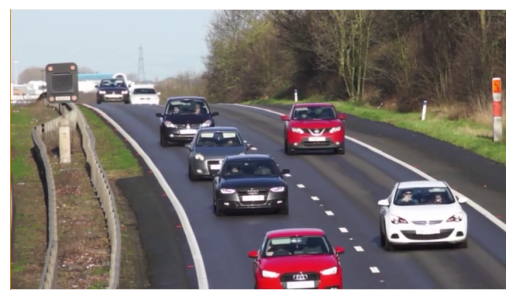

In [4]:
plt.imshow(mpimg.imread(os.path.join(os.getcwd(), 'out', 'before.png')))
plt.axis('off')
plt.show()

# Load a Detector 

In [5]:
# initializes the object detector (Yolo Detector). 
# passing the video's height and width.
yolodet = c4d.detectors.yolo(height = height, width = width)

# Define Kalman Parameters

In [6]:
# x(t) = A(t) * x(t-1) + e(t) || e(t) ~ N(0,Q(t))
# z(t) = H(t) * x(t) + r(t)   || r(t) ~ N(0,R(t))

# x(t) = [x1 y1 x2 y2 vx vy]

A = np.array([[1, 0, 0, 0, dt, 0 ]
            , [0, 1, 0, 0, 0,  dt]
            , [0, 0, 1, 0, dt, 0 ]
            , [0, 0, 0, 1, 0,  dt]
            , [0, 0, 0, 0, 1,  0 ]
            , [0, 0, 0, 0, 0,  1 ]])

H = np.array([[1, 0, 0, 0, 0, 0]
            , [0, 1, 0, 0, 0, 0]
            , [0, 0, 1, 0, 0, 0]
            , [0, 0, 0, 1, 0, 0]])

P = np.eye(A.shape[1])

Q = np.array([[25, 0,  0,  0,  0,  0]
            , [0,  25, 0,  0,  0,  0]
            , [0,  0,  25, 0,  0,  0]
            , [0,  0,  0,  25, 0,  0]
            , [0,  0,  0,  0,  49, 0]
            , [0,  0,  0,  0,  0,  49]])

R = dt * np.eye(4)


# Tracker = Data Point + Kalman Filter
### (Data point and Kalman filter are core elements of C4dynamics)

In [7]:
class tracker(c4d.datapoint):
    # a datapoint 
    # kalman filter 
    # display color
    ## 
    
    def __init__(obj, z):

        super().__init__()  # Call the constructor of c4d.datapoint
         
        obj.filter = c4d.filters.kalman(np.hstack((z, np.zeros(2))), P, A, H, Q, R)
        
        obj.counterSame = 0
        obj.counterEscaped = 0
        obj.appear = 0

        obj.color = [np.random.randint(0, 255)
                     , np.random.randint(0, 255)
                     , np.random.randint(0, 255)]

    def update(obj, measure):
        if obj.isvalid(measure):
            obj.counterEscaped = 0
            obj.appear += 1
            obj.filter.correct(measure)

    def isvalid(obj, measure):
        innovation = measure - np.dot(obj.filter.H, obj.filter.x)
        if obj.appear < 8:
            return True
        '''
            Innovation test.
        '''
        S = np.dot(obj.filter.H, np.dot(obj.filter.P, obj.filter.H.T)) + obj.filter.R
        epsilon = np.dot(innovation.T, np.dot(np.linalg.inv(S), innovation))
        return epsilon < 9.488 # chi

    def showdetection(obj):
        if obj.appear > 10: 
            obj.appear = 10
        return obj.appear > 2
        
    def nextposition(obj):
        state = obj.filter.x[:4]
        state = state.astype(np.int32)
        return np.array(state)

    def getvelocity(obj):
        state = obj.filter.x[4:]
        state = state.astype(np.int32)
        return state

    def getcenter(obj):
        state = obj.nextposition()
        center = np.zeros(2)
        center[0] = 0.5 * (state[0] + state[2])
        center[1] = 0.5 * (state[1] + state[3])
        return center.astype(np.int32)

    def remove(obj):
        obj.counterEscaped += 1
        if obj.counterEscaped > 40:
            return True
        return False
    
    def __eq__(obj, other):
        x1 = obj.nextposition()
        x2 = other.nextposition()
        if np.linalg.norm(x1 - x2) < 10: 
            return True        

# Trackers Manager

### (a dictionary of trackers and methods to add and remove elements)

In [8]:
# trackers manager:
#   list of active trackers
#   add or remove tracks methods
class mTracks:
    def __init__(obj):
        obj.trackers = {}
        obj.removelist = []
        obj.neigh = NearestNeighbors(n_neighbors = 1)
        obj.thresh = 100 # threshold of 100 pixels to verify the measure is close enough to the object. 

    def add(obj, key, z):
        obj.trackers[key] = tracker(z)
    
    def remove(obj):
        for key in obj.removelist:
            print(f'deleted existing data with key: {key}')
            try: 
                obj.trackers.pop(key)
            except: 
                print('deleted this key before')

        obj.removelist = []

        
    def refresh(obj, zList, frame, t):
        # updates the state of each tracker, performs 
        # measurements handling and association with the nearest neighbor, 
        # and visualizes the tracked objects on the frame.
        ## 
        for key, kf in obj.trackers.items():
            #
            # predict
            ##
            obj.trackers[key].filter.predict()
            obj.trackers[key].counterEscaped += 1 # i dont understnad why to advanethe escaepe counter in predict? 
            remove = obj.trackers[key].remove()     
            
            #
            # correct
            ## 
            iscorrect = False
            if remove:
                obj.removelist.append(key) # whouldnt it go now to the head of the loop? 
                
            kfPose = np.expand_dims(obj.trackers[key].nextposition(), axis = 0)
            
            if zList.shape[0] >= 2:
                # if more than one measure, check which is the closest. 
                d, relativeIndex = obj.neigh.kneighbors(kfPose)
                if d[0][0] < obj.thresh:                    
                    # if the measure is not too far from the object 
                    distances = d[0]
                    z = np.array(zList)[relativeIndex[0]]
                    if len(z) == 1:
                        measurement = z[0]
                    else:
                        npDistances = np.array(distances)
                        npDistances = npDistances * npDistances
                        weights = 1 - npDistances / np.sum(npDistances)
                        # return np.average(z, weights = weights, axis = 0)
                        measurement = np.average(z, weights = weights, axis = 0)
                    
                    obj.trackers[key].update(measurement)
                    iscorrect = True
                else:
                    remove = obj.trackers[key].remove()
                    if remove:
                        obj.removelist.append(key)
                        continue 
                        
            elif zList.shape[0] == 1:
                # is exactly one measure exists, no need to check which is closest 
                # how it knows that it belobgs to this track? 
                measurement = zList[0]
                obj.trackers[key].Update(measurement)
                iscorrect = True
                
            pose = obj.trackers[key].nextposition()
            vel = obj.trackers[key].getvelocity() * dt
            center = obj.trackers[key].getcenter()
            color = kf.color
            
            obj.trackers[key].x = center[0]
            obj.trackers[key].y = center[1]
            obj.trackers[key].vx = vel[0]
            obj.trackers[key].vy = vel[1]
            if iscorrect:
                obj.trackers[key].az = 1
            else:
                obj.trackers[key].az = 0

            obj.trackers[key].store(t)

            if obj.trackers[key].showdetection():
                cv2.rectangle(frame, (pose[0], pose[1]), (pose[2], pose[3]), color,2)
                cv2.putText(frame, 'id: ' + str(key), (center + [0, -10]), cv2.FONT_HERSHEY_PLAIN, 1, color, 2)
                cv2.arrowedLine(frame, center, center + vel.astype(np.int32), color, 4)
    
    def trackerMaker(obj, zList, cov):
        # updates the existing trackers based on a list of
        # new observations zList. 
        # uses the Nearest Neighbors algorithm to 
        # find the nearest observation for each tracker, associates them, and 
        # then creates new trackers for any unassociated observations.
        
        RestOfZ = np.copy(zList)
        check = NearestNeighbors(n_neighbors = 1)
        check.fit(zList)
        AssociatedZ = []
        delist = []
        
        for kf in obj.trackers.values():
            
            kfPose = [kf.nextposition()]
            _, idx = check.kneighbors(kfPose)
            
            if idx[0][0] not in delist:
                AssociatedZ.append(zList[idx[0][0]])
                delist.append(idx[0][0])
                
                
        AssociatedZ = np.array(AssociatedZ)
        RestOfZ = np.delete(RestOfZ, delist, 0)
        
        if list(obj.trackers.keys()):
            lastKey = list(obj.trackers.keys())[-1] + 1
            while lastKey in list(obj.trackers.keys()):
                lastKey += 1
        else:
            lastKey = 0
            
        RestOfZSize = AssociatedZ.shape[0]
        
        if RestOfZSize > 0 and not lastKey == 0:
            check.fit(AssociatedZ)
            
        UpdateTracker = True
        n = zList.shape[1]
        
        
        for z in RestOfZ:
            
            if not lastKey == 0 and RestOfZSize > 0:
                
                UpdateTracker = False
                _, idx = check.kneighbors([z])
                v = z - AssociatedZ[idx[0][0]]
                epsilon = np.dot(v.T, np.dot(np.linalg.inv(cov), v))
                
                if n == 2 and not epsilon < 5.991: 
                    UpdateTracker = True
                elif n == 4 and  not epsilon < 9.448: 
                    UpdateTracker = True
            
            if UpdateTracker:
                print(f'following new data with key: {lastKey}')
                
                obj.add(lastKey, z)
                
                lastKey += 1
                UpdateTracker = False

    def RemoveDoubles(obj, threshold = 10):
        # removes duplicate trackers that are close to each other. 
        # compares each tracker with every other tracker and removes the 
        # duplicates based on a given threshold.
        
        keys = list(obj.trackers.keys())
        KeysVisited = []
        KeysRemove = []
        
        for key in keys:
            for inKey in keys:
                if key == inKey or inKey in KeysVisited:
                    continue
                if obj.trackers[key] == obj.trackers[inKey]:
                    if(obj.trackers[inKey].remove()):
                        KeysRemove.append(inKey)
            KeysVisited.append(key)
            
        for inKey in KeysRemove:
            print("Removing doubles")
            print(f'deleted existing data with key: {inKey}')
            try: 
                obj.trackers.pop(inKey)
            except: 
                print('deleted this key before')


# Main Loop

In [9]:
def run(tf = 1):
    
    mtracks = mTracks()
    
    cov = 25 * np.eye(4)
    t = 0
    
    while video.isOpened():
        
        ret, frame = video.read()
        # frame = frame.astype(np.uint8)
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Assuming input frames are in BGR format
        
        if not ret: 
            break
        #
        # the update function runs the main trackers loop.  
        ##
        zList = yolodet.getMeasurements(frame) # retrieves object measurements from the current frame using the object detector (YoloDetector).
        
        
        # updates the trackers dictionary by adding or removing tracks.  
        # creates new trackers if there are more 
        # measurements than trackers and removes duplicate trackers if 
        # there are more trackers than measurements.
        kfNumber = len(mtracks.trackers.keys())
        zNumber = zList.shape[0]
        
        if kfNumber < zNumber:
            # more measurements than trackers
            mtracks.trackerMaker(zList, cov)
            
        elif kfNumber > zNumber and zNumber > 0:
            # more trackers than measurements
            mtracks.RemoveDoubles()
        
        
        # fits the Nearest Neighbors algorithm to the object 
        # measurements for association purposes.
        if zList.shape[0] >= 2:
            mtracks.neigh.fit(zList)


        mtracks.refresh(zList, frame, t)
        mtracks.remove()

        cv2.imshow('image', frame)
        result.write(frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or t >= tf:
            break
        
        t += dt
        
    cv2.destroyAllWindows()
    result.release()
    return mtracks


# Run

In [10]:
ltrk = run(tf = 2)

following new data with key: 0
following new data with key: 1
following new data with key: 2
following new data with key: 3
following new data with key: 4
following new data with key: 5
following new data with key: 6
following new data with key: 7
following new data with key: 8
following new data with key: 9
deleted existing data with key: 3
following new data with key: 10
following new data with key: 11
following new data with key: 12


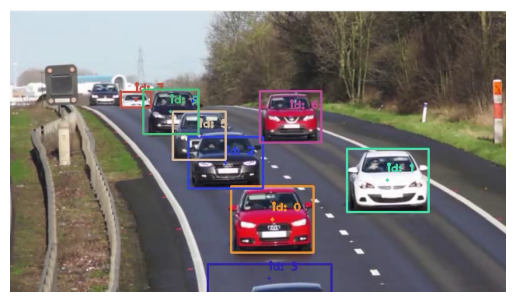

In [11]:
plt.imshow(mpimg.imread(os.path.join(os.getcwd(), 'out', 'after.png')))
plt.axis('off')
plt.show()

# Results Analysis

12


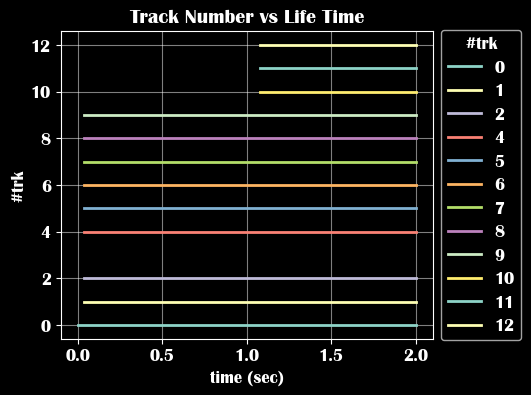

In [12]:
print(len(ltrk.trackers))

plt.rcParams["font.family"] = "Britannic Bold" # "Modern Love"#  "Corbel Bold"# "Times New Roman"
plt.rcParams["font.size"] = 12
# plt.style.use()
# plt.style.use('ggplot') # 'dark_background' # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
plt.style.use('dark_background')  # 'default' # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('default')  # 'seaborn' # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('seaborn') # 'fivethirtyeight' # 'classic' # 'bmh'
# plt.style.use('fivethirtyeight')  # 'classic' # 'bmh'
# plt.style.use('classic')  # 'bmh'
# plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
plt.ion()

fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    vtotal = np.sqrt(v.get_vx()**2 + v.get_vy()**2 + v.get_vz()**2)
    ax.plot(v.get_t(), k * np.ones(v.get_t().shape), linewidth = 2, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'time (sec)',ylabel = '#trk')
ax.set_title('Track Number vs Life Time')
ax.grid(alpha = 0.5)

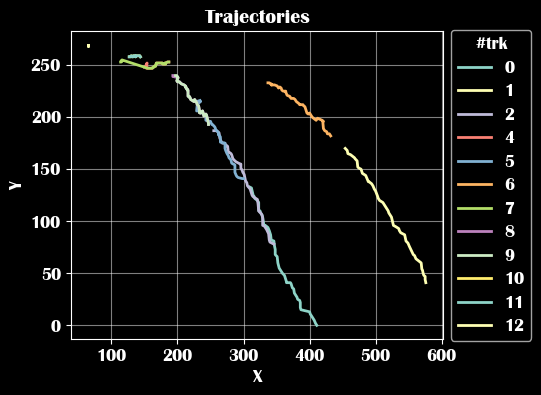

In [13]:

fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    ax.plot(v.get_x(), height - v.get_y(), linewidth = 2, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'X',ylabel = 'Y')
ax.set_title('Trajectories')
ax.grid(alpha = 0.5)

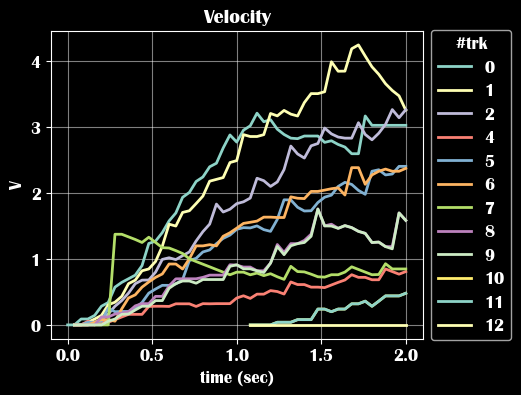

In [14]:
fig = plt.figure
ax = plt.subplot(111)

for k, v in ltrk.trackers.items():
    vtotal = np.sqrt(v.get_vx()**2 + v.get_vy()**2 + v.get_vz()**2)
    ax.plot(v.get_t(), vtotal, linewidth = 2, label = str(k))

plt.legend(title = 'trk')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title = '#trk', loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'time (sec)',ylabel = 'V')
ax.set_title('Velocity')
ax.grid(alpha = 0.5)